# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Для начала импортируем необходимые модули и функции.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

Далее, загрузим данные и ознакомимся с ними, убедимся, что данные пригодны для работы и не требуют предообработки.

In [43]:
df = pd.read_csv('/datasets/users_behavior.csv')

df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [45]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Числовое описание данных в норме. Показатели центральной тенденции у всех признаков в норме, нет указаний на явные выбросы.
Однако дополнительно рассмотрим графики, что бы точно в этом убедиться.

In [46]:
df_info = df.drop('is_ultra', axis=1)

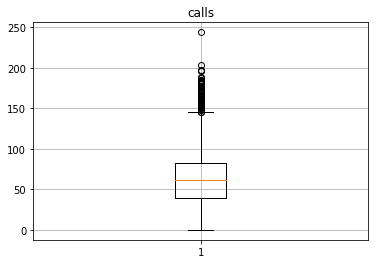

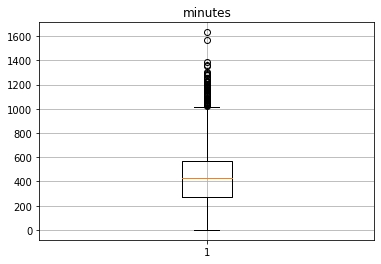

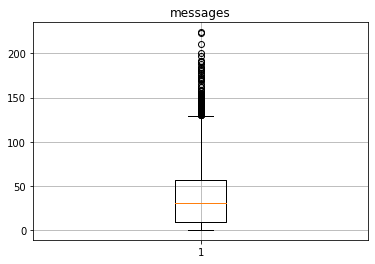

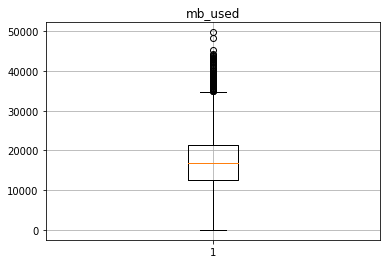

In [47]:
columns = df_info.columns
for col in columns:
    plt.boxplot(df_info[col])
    plt.grid()
    plt.title(col)
    plt.show()

В выборке присутствуют некоторые выборосы, однако они не критичны. Данные можно использовать для обучение и проверки моделей.

## Разбейте данные на выборки

В данном пункте разобьем исходную выборку на три:

- Обучующую;
- Валидативную;
- Тестовую;

Разбитие выборок будем производить в пропорциях: 60% / 20% / 20%.

In [48]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [49]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                               test_size=0.2, random_state=1234)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train,
                                                                               test_size=0.25, random_state=1234)
print('Тренировочная база:', features_train.shape, target_train.shape)
print('Валидная база:', features_valid.shape, target_valid.shape)
print('Тестовая база:', features_test.shape, target_test.shape)

Тренировочная база: (1928, 4) (1928,)
Валидная база: (643, 4) (643,)
Тестовая база: (643, 4) (643,)


In [50]:
all_size = df.shape[0]
train_size = features_train.shape[0]
valid_size = features_valid.shape[0]
test_size = features_test.shape[0]

print(f'Процент объектов в обучающей выборке: {(train_size / all_size):.2f}')
print(f'Процент объектов в валидной выборке: {(valid_size / all_size):.2f}')
print(f'Процент объектов в тестовой выборке: {(test_size / all_size):.2f}')

Процент объектов в обучающей выборке: 0.60
Процент объектов в валидной выборке: 0.20
Процент объектов в тестовой выборке: 0.20


Разбитие исходной выборки на тренировочную, валидирующую и тестовую выполнены.

## Исследуйте модели

Теперь, исследуем три модели классификации: решающее дерево, случайный лес и логистическую регрессию.

Начнём с дерева. Найдем глубину дерева, при которой модель покажет наилучший результат на валидирующей выборке и сохраним его в переменную.

In [51]:
best_score_1 = 0
best_depth_1 = 0

for depth in range(1,50):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, result)
    if accuracy > best_score_1:
        best_score_1 = accuracy
        best_depth_1 = depth
print('Лучшая оценка:', best_score_1)
print('Глубина дерева:', best_depth_1)

Лучшая оценка: 0.7931570762052877
Глубина дерева: 9


Далее рассмотрим модель рандомного леса, найдем наилучшее сочетание глубины дерева и количества деревьем на валидирующей выборке, результаты и параметры модели сохраним в переменные.

In [52]:
best_score_2 = 0
best_depth_2 = 0
best_est = 0

for depth in range(1,15):
    for est in range(1,50):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        result = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, result)
        if accuracy > best_score_2:
            best_score_2 = accuracy
            best_depth_2 = depth
            best_est = est
print('Лучшая оценка:', best_score_2)
print('Глубина дерева:', best_depth_2)
print('Количество деревьев:', best_est)

Лучшая оценка: 0.8242612752721618
Глубина дерева: 11
Количество деревьев: 27


И в конце проверим логистическуб регрессию. Сохраним оценку модули на валидирубщей выборке в переменную.

In [53]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
result = model.predict(features_valid)
best_score_3 = accuracy_score(target_valid, result)
print('Лучшая оценка:', best_score_3)

Лучшая оценка: 0.7293934681181959


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Получим таблицу с результатами и выберем наилучшую, с точки зрения оценки, модель и её параметры.

In [54]:
data = {
    'score': [best_score_1, best_score_2, best_score_3],
    'depth': [best_depth_1, best_depth_2, None],
    'est': [None, best_est, None]
}
result_df = pd.DataFrame(data, index=['Решающее дерево', 'Случайный Лес', 'Логистическая Регрессия'])
result_df

,score,depth,est
Решающее дерево,0.793157,9.0,NaN
Случайный Лес,0.824261,11.0,27.0
Логистическая Регрессия,0.729393,NaN,NaN


Наилучший результат показала модель *случайный лес*.

## Проверьте модель на тестовой выборке

Далее, проверим как покажет себя выбранная нами модель на тестовой выборке.

In [55]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_2, n_estimators=best_est)
model.fit(features_train, target_train)
result = model.predict(features_test)
accuracy = accuracy_score(target_test, result)
print('Оценка модели:', accuracy)

Оценка модели: 0.8087091757387247


Результат несколько хуже, чем на валидирубщей выборке, однако удовлетворяет изначальной задаче - добиться оценки выше 0.75. Поэтому можем считать данную модель с данными гиперпараметрами удовлетворяющую условиям задачи.

## Проверка модели на адекватность

Судя по матрице ошибок модель верно определила примерно половину категорий "0". Скорее всего, это говорит о необходимости доработки модели, даже при условии прохождения по требованию оценки.

Поскольку мы имеет в работе биноминальную классификацию, для проверки на адекватность можно использовать: константы 0 или 1, и рандомное присваивание меток. Оценки для этих проверок должны быть:

*1) Равны долям констант в тестовой выборке.*

*2) Стремиться к 0.5, если считать, что выбор производится случайно, а шанс верно присвоить метку равен P=0.5.*

Применим структуру данных DummyClassifier, посчитает оценки модели для каждого случая и сравним с выбранной моделью.

В первом случание, модель будет всегда присваивать наиболее часто встречающуюся метку. В нашем случание это 0.

In [57]:
model = DummyClassifier(strategy='most_frequent', random_state=12345)
model.fit(features_train, target_train)
result_test = model.predict(features_test)
accuracy_test = accuracy_score(target_test, result_test)
print('Оценка модели:', accuracy_test)

Оценка модели: 0.6998444790046656


In [58]:
confusion_matrix(target_test, result_test)

array([[450,   0],
       [193,   0]])

Далее, пусть модель всегда присваивает менее встречающуюся метку.

In [59]:
model = DummyClassifier(strategy='constant', random_state=12345, constant=1)
model.fit(features_train, target_train)
result_test_2 = model.predict(features_test)
accuracy_test_2 = accuracy_score(target_test, result_test_2)
print('Оценка модели:', accuracy_test_2)

Оценка модели: 0.3001555209953344


In [60]:
confusion_matrix(target_test, result_test_2)

array([[  0, 450],
       [  0, 193]])

И, наконец, случаный выбор метки.

In [61]:
model = DummyClassifier(strategy='stratified', random_state=12345)
model.fit(features_train, target_train)
result_test_3 = model.predict(features_test)
accuracy_test_3 = accuracy_score(target_test, result_test_3)
print('Оценка модели:', accuracy_test_3)

Оценка модели: 0.6018662519440124


In [62]:
confusion_matrix(target_test, result_test_3)

array([[323, 127],
       [129,  64]])

Как видно из результатов, выбранная в 4 пунтке модель, выполняет классификацию с лучшей точностью, чем модели, присваивающие метки в виде констант или же случайным присваиванием. Это говорит о правильности выбранной модели.

### Общий вывод по работе

В ходе работы был загружен и проверян на пригодность к работе датасет с информацией о клиентах компании. Далее, датасет был разбит на три выборки в пропорциях 0.6/0.2/0.2 для обучение, валидации и теста модели.

Далее, был исследованы три типа модели с изменением гиперпараметров:

- Решающее дерево;
- Случайный лес;
- Логистическая регрессия;

В ходе валидации, было определено, что наилучшую оценку (0.824) показывает модель случайного леса с глубиной 11 и числом деревьев 27.

Далее, выбранная модель была проверена на тестовой выборке, где показала оценку 0.808, что полностью удовлетворет условиям задачи.

В конце работы была проверена адекватность модели. Результаты выбранной модели сравнили с результатами моделей, которые присваивали метки классификации в виде констант, а так же рандомно. По результатам оценки, выбранная модель признана адекватной.